In [1]:
import pandas as pd
import sqlite3

In [2]:
conn = sqlite3.connect('..\\data\\checking-logs.sqlite.sqlite_copy')

In [3]:
commits = pd.io.sql.read_sql(
    """
    select date(timestamp) as date, cast(strftime('%H', timestamp) as integer) as hour from checker where uid like 'user_%'
    """,
    conn, parse_dates=['date']
    )
commits

,date,hour
0,2020-04-17,5
1,2020-04-17,5
2,2020-04-17,5
3,2020-04-17,5
4,2020-04-17,5
...,...,...
3202,2020-05-21,20
3203,2020-05-21,20
3204,2020-05-21,20
3205,2020-05-21,20


In [4]:
dff = commits.groupby('hour').count()
dff

,date
hour,
0,12
1,6
3,3
5,17
6,3
7,47
8,65
9,52
10,160


## Разбиваеи по будням и выходным

In [5]:
working_day = commits[commits['date'].dt.dayofweek < 5]
weekend = commits[commits['date'].dt.dayofweek >= 5]
# weekend.drop('date', axis=1, inplace=True)

In [7]:
weekend.head()

,date,hour
23,2020-04-18,7
24,2020-04-18,13
25,2020-04-18,13
26,2020-04-18,13
27,2020-04-18,13


## Ищем средние значения

In [8]:
df1 = working_day.groupby(['date', 'hour']).agg({'hour': 'count'})
df3 = weekend.groupby(['date', 'hour']).agg({'hour': 'count'})
df1 = df1.unstack(1)
df3 = df3.unstack(1)
# weekend.droplevel(0)
# weekend.rename(columns={'date': 'weekend'}, inplace=True)
df2 = df1.mean()
df4 = df3.mean()
df = pd.concat([df4, df2], axis=1)
df.fillna(0, inplace=True)
df.reset_index(inplace=True)
df.drop('level_0', inplace=True, axis=1)
df.set_index('hour', inplace=True)
index = pd.RangeIndex(stop=24)
df_1 = df.reindex(index=index, fill_value=0)
df_1.rename(columns={df_1.columns[1]: 'working_day', df_1.columns[0]: 'weekend'}, inplace=True)
df_1 = df_1.rename_axis('hour')
df_1
# df = pd.concat([working_day, weekend], axis=1)

,weekend,working_day
hour,,
0,2.000000,3.000000
1,6.000000,0.000000
2,0.000000,0.000000
3,1.000000,2.000000
4,0.000000,0.000000
5,2.000000,7.500000
6,0.000000,1.500000
7,4.000000,5.166667
8,7.000000,3.700000


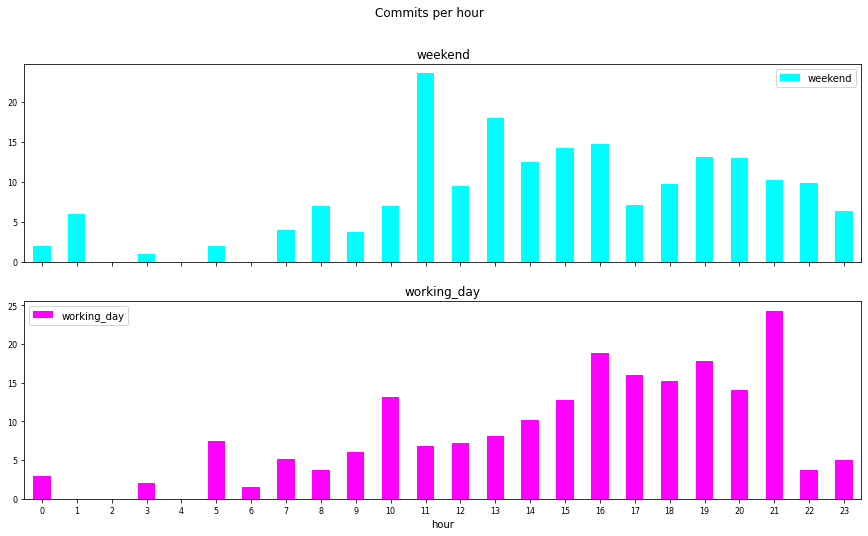

In [11]:
ax = df_1.plot.bar(figsize=(15, 8), title='Commits per hour', rot=0, fontsize=8,
                 colormap='cool', subplots=True)

## Час, когда происходит наибольшее число коммитов в будние дни – 21
## Час, когда происходит наибольшее число коммитов в выходные – 11

In [12]:
conn.close()